### Recap: Domain decomposition theory

Given a linear operator $A : V \to V$, suppose we have a collection of prolongation operators $P_i : V_i \to V$.  The columns of $P_i$ are "basis functions" for the subspace $V_i$.  The Galerkin operator $A_i = P_i^T A P_i$ is the action of the original operator $A$ in the subspace.

Define the subspace projection

$$ S_i = P_i A_i^{-1} P_i^T A . $$

* $S_i$ is a projection: $S_i^2 = S_i$
* If $A$ is SPD, $S_i$ is SPD with respect to the $A$ inner product $x^T A y$
* $I - S_i$ is $A$-orthogonal to the range of $P_i$

Note, the concept of $A$-orthogonality is meaningful only when $A$ is SPD.
Does the mathematical expression $ P_i^T A (I - S_i) = 0 $ hold even when $A$ is nonsymmetric?

These projections may be applied additively

$$ I - \sum_{i=0}^n S_i, $$

multiplicatively

$$ \prod_{i=0}^n (I - S_i), $$

or in some hybrid manner, such as

$$ (I - S_0) (I - \sum_{i=1}^n S_i) . $$
In each case above, the action is expressed in terms of the error iteration operator.

### Examples

* Jacobi corresponds to the additive preconditioner with $P_i$ as the $i$th column of the identity
* Gauss-Seidel is the multiplicate preconditioner with $P_i$ as the $i$th column of the identity
* Block Jacobi corresponds to labeling "subdomains" and $P_i$ as the columns of the identity corresponding to non-overlapping subdomains
* Overlapping Schwarz corresponds to overlapping subdomains
* $P_i$ are eigenvectors of $A$
* A domain is partitioned into interior $V_{I}$ and interface $V_\Gamma$ degrees of freedom.  $P_{I}$ is embedding of the interior degrees of freedom while $P_\Gamma$ is "harmonic extension" of the interface degrees of freedom.  Consider the multiplicative combination $(I - S_\Gamma)(I - S_{I})$.

### Convergence theory

The formal convergence is beyond the scope of this course, but the following estimates are useful.  We let $h$ be the element diameter, $H$ be the subdomain diameter, and $\delta$ be the overlap, each normalized such that the global domain diameter is 1.  We express the convergence in terms of the condition number $\kappa$ for the preconditioned operator.

* (Block) Jacobi: $\delta=0$, $\kappa \sim H^{-2} H/h = (Hh)^{-1}$
* Overlapping Schwarz: $\kappa \sim H^{-2} H/\delta = (H \delta)^{-1}$
* 2-level overlapping Schwarz: $\kappa \sim H/\delta$

### Hands-on with PETSc: demonstrate these estimates

* Linear Poisson with geometric multigrid: `src/ksp/ksp/examples/tutorials/ex29.c`
* Nonlinear problems
  * Symmetric scalar problem: `src/snes/examples/tutorials/ex5.c`
  * Nonsymmetric system (lid/thermal-driven cavity): `src/snes/examples/tutorials/ex19.c`
* Compare preconditioned versus unpreconditioned norms.
* Compare BiCG versus GMRES
* Compare domain decomposition and multigrid preconditioning
 * `-pc_type asm` (Additive Schwarz)
  * `-pc_asm_type basic` (symmetric, versus `restrict`)
  * `-pc_asm_overlap 2` (increase overlap)
  * Effect of direct subdomain solver: `-sub_pc_type lu`
 * `-pc_type mg` (Geometric Multigrid)
* Use monitors:
 * `-ksp_monitor_true_residual`
 * `-ksp_monitor_singular_value`
 * `-ksp_converged_reason`
* Explain methods: `-snes_view`
* Performance info: `-log_view`

#### Example: Inhomogeneous Poisson

$$ -\nabla\cdot \Big( \rho(x,y) \nabla u(x,y) \Big) = e^{-10 (x^2 + y^2)} $$

in $\Omega = [0,1]^2$ with variable conductivity

$$\rho(x,y) = \begin{cases}
    \rho_0 & (x,y) \in [1/3, 2/3]^2 \\
    1 & \text{otherwise}
    \end{cases} $$
    
where $\rho_0 > 0$ is a parameter (with default $\rho_0 = 1$).

In [18]:
%%bash

# You may need to change these for your machine
PETSC_DIR=$HOME/petsc PETSC_ARCH=ompi-optg

# Build the example
make -C $PETSC_DIR -f gmakefile $PETSC_ARCH/tests/ksp/ksp/examples/tutorials/ex29

# Link it from the current directory to make it easy to run below
cp -sf $PETSC_DIR/$PETSC_ARCH/tests/ksp/ksp/examples/tutorials/ex29 .

make: Entering directory '/home/jed/petsc'
make: 'ompi-optg/tests/ksp/ksp/examples/tutorials/ex29' is up to date.
make: Leaving directory '/home/jed/petsc'


In [129]:
# Prints solution DM and then a coordinate DM
! mpiexec -n 2 ./ex29 -da_refine 2 -dm_view

DM Object: 2 MPI processes
  type: da
Processor [0] M 9 N 9 m 1 n 2 w 1 s 1
X range of indices: 0 9, Y range of indices: 0 5
Processor [1] M 9 N 9 m 1 n 2 w 1 s 1
X range of indices: 0 9, Y range of indices: 5 9
DM Object: 2 MPI processes
  type: da
Processor [0] M 9 N 9 m 1 n 2 w 2 s 1
X range of indices: 0 9, Y range of indices: 0 5
Processor [1] M 9 N 9 m 1 n 2 w 2 s 1
X range of indices: 0 9, Y range of indices: 5 9


In [134]:
! mpiexec -n 2 ./ex29 -rho 1e-1 -da_refine 3 -ksp_view_solution draw -draw_pause 5 -draw_cmap plasma

This problem is nonsymmetric due to boundary conditions, though symmetric solvers like CG and MINRES may still converge

In [141]:
! mpiexec -n 2 ./ex29 -rho 1e-1 -da_refine 3 -ksp_monitor_true_residual -ksp_view -ksp_type gmres

  0 KSP preconditioned resid norm 1.338744788815e-02 true resid norm 1.433852280437e-02 ||r(i)||/||b|| 1.000000000000e+00
  1 KSP preconditioned resid norm 6.105013156491e-03 true resid norm 8.819020609674e-03 ||r(i)||/||b|| 6.150578222039e-01
  2 KSP preconditioned resid norm 3.380566739974e-03 true resid norm 3.966597605983e-03 ||r(i)||/||b|| 2.766392089410e-01
  3 KSP preconditioned resid norm 2.248884854426e-03 true resid norm 1.950654466953e-03 ||r(i)||/||b|| 1.360429169426e-01
  4 KSP preconditioned resid norm 1.603958727893e-03 true resid norm 1.729343487982e-03 ||r(i)||/||b|| 1.206082043163e-01
  5 KSP preconditioned resid norm 1.017005335066e-03 true resid norm 1.108652090238e-03 ||r(i)||/||b|| 7.731982613301e-02
  6 KSP preconditioned resid norm 5.817999897588e-04 true resid norm 7.954596575686e-04 ||r(i)||/||b|| 5.547709958842e-02
  7 KSP preconditioned resid norm 3.102671011646e-04 true resid norm 4.651546500795e-04 ||r(i)||/||b|| 3.244090457755e-02
  8 KSP preconditioned r

### Default parallel solver

* Krylov method: GMRES
  * restart length of 30 to bound memory requirement and orthogonalization cost
  * classical Gram-Schmidt (compare `-ksp_gmres_modifiedgramschmidt`)
  * left preconditioning, uses preconditioned norm
  $$ P^{-1} A x = P^{-1} b $$
  * `-ksp_norm_type unpreconditioned`
  $$ A P^{-1} (P x) = b $$
  * Can estimate condition number using Hessenberg matrix
    * `-ksp_monitor_singular_value`
    * `-ksp_view_singularvalues`
    * Contaminated by restarts, so turn off restart `-ksp_gmres_restart 1000` for accurate results
* Preconditioner: block Jacobi
  * Expect condition number to scale with $1/(H h)$ where $H$ is the subdomain diameter and $h$ is the element size
  * One block per MPI process
    * No extra memory to create subdomain problems
    * Create two blocks per process: `-pc_bjacobi_local_blocks 2`
  * Each subdomain solver can be configured/monitored using the `-sub_` prefix
    * `-sub_ksp_type preonly` (default) means just apply the preconditioner
  * Incomplete LU factorization with zero fill
    * $O(n)$ cost to compute and apply; same memory as matrix $A$
    * gets weaker as $n$ increases
    * can fail unpredictably at the worst possible time
    * Allow "levels" of fill: `-sub_pc_factor_levels 2`
  * Try `-sub_pc_type lu`

In [147]:
! mpiexec -n 2 ./ex29 -rho 1e-1 -da_refine 3 -ksp_monitor -ksp_view -sub_pc_factor_levels 3

  0 KSP Residual norm 3.321621226957e-02 
  1 KSP Residual norm 6.488371997792e-03 
  2 KSP Residual norm 3.872608843511e-03 
  3 KSP Residual norm 2.258796172567e-03 
  4 KSP Residual norm 6.146527388370e-04 
  5 KSP Residual norm 4.540373464970e-04 
  6 KSP Residual norm 1.994013489521e-04 
  7 KSP Residual norm 2.170446909144e-05 
  8 KSP Residual norm 7.079429242940e-06 
  9 KSP Residual norm 2.372198219605e-06 
 10 KSP Residual norm 9.203675161062e-07 
 11 KSP Residual norm 2.924907588760e-07 
KSP Object: 2 MPI processes
  type: gmres
    restart=30, using Classical (unmodified) Gram-Schmidt Orthogonalization with no iterative refinement
    happy breakdown tolerance 1e-30
  maximum iterations=10000, initial guess is zero
  tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
  left preconditioning
  using PRECONDITIONED norm type for convergence test
PC Object: 2 MPI processes
  type: bjacobi
    number of blocks = 2
    Local solve is same for all blocks, in the follow

### Scaling estimates

#### Dependence on $h$

In [54]:
! mpiexec -n 16 --oversubscribe ./ex29 -da_refine 3 -sub_pc_type lu -ksp_gmres_restart 1000 -ksp_converged_reason -ksp_view_singularvalues

Linear solve converged due to CONVERGED_RTOL iterations 20
Iteratively computed extreme singular values: max 1.9384 min 0.0694711 max/min 27.9023


In [60]:
%%bash

for refine in {4..8}; do
  mpiexec -n 16 --oversubscribe ./ex29 -da_refine $refine -sub_pc_type lu -ksp_gmres_restart 1000 -ksp_converged_reason -ksp_view_singularvalues
done

Linear solve converged due to CONVERGED_RTOL iterations 27
Iteratively computed extreme singular values: max 1.98356 min 0.0338842 max/min 58.5395
Linear solve converged due to CONVERGED_RTOL iterations 36
Iteratively computed extreme singular values: max 2.04703 min 0.0167502 max/min 122.209
Linear solve converged due to CONVERGED_RTOL iterations 47
Iteratively computed extreme singular values: max 2.12834 min 0.00830794 max/min 256.182
Linear solve converged due to CONVERGED_RTOL iterations 62
Iteratively computed extreme singular values: max 2.1865 min 0.00412757 max/min 529.731
Linear solve converged due to CONVERGED_RTOL iterations 82
Iteratively computed extreme singular values: max 2.22724 min 0.00206119 max/min 1080.56


In [95]:
%%bash

for refine in {3..8}; do
  mpiexec -n 16 --oversubscribe ./ex29 -da_refine $refine -pc_type asm -sub_pc_type lu -ksp_gmres_restart 1000 -ksp_converged_reason -ksp_view_singularvalues
done

Linear solve converged due to CONVERGED_RTOL iterations 12
Iteratively computed extreme singular values: max 1.39648 min 0.183011 max/min 7.63057
Linear solve converged due to CONVERGED_RTOL iterations 16
Iteratively computed extreme singular values: max 1.68852 min 0.0984075 max/min 17.1584
Linear solve converged due to CONVERGED_RTOL iterations 23
Iteratively computed extreme singular values: max 1.8569 min 0.0494302 max/min 37.5661
Linear solve converged due to CONVERGED_RTOL iterations 31
Iteratively computed extreme singular values: max 1.9503 min 0.0247646 max/min 78.7537
Linear solve converged due to CONVERGED_RTOL iterations 41
Iteratively computed extreme singular values: max 2.03979 min 0.0123563 max/min 165.081
Linear solve converged due to CONVERGED_RTOL iterations 54
Iteratively computed extreme singular values: max 2.12275 min 0.00615712 max/min 344.764


In [96]:
%%bash
cat > results.csv <<EOF
method,refine,its,cond
bjacobi,3,20,27.90
bjacobi,4,27,58.54
bjacobi,5,36,122.2
bjacobi,6,47,256.2
bjacobi,7,62,529.7
bjacobi,8,82,1080.6
asm,3,12,7.63
asm,4,16,17.15
asm,5,23,37.57
asm,6,31,78.75
asm,7,41,165.1
asm,8,54,344.8
EOF

,method,refine,its,cond,P,N,h,H,1/Hh
0,bjacobi,3,20,27.90,16,256,0.062500,0.25,64.0
1,bjacobi,4,27,58.54,16,1024,0.031250,0.25,128.0
2,bjacobi,5,36,122.20,16,4096,0.015625,0.25,256.0
3,bjacobi,6,47,256.20,16,16384,0.007812,0.25,512.0
4,bjacobi,7,62,529.70,16,65536,0.003906,0.25,1024.0
5,bjacobi,8,82,1080.60,16,262144,0.001953,0.25,2048.0
6,asm,3,12,7.63,16,256,0.062500,0.25,64.0
7,asm,4,16,17.15,16,1024,0.031250,0.25,128.0
8,asm,5,23,37.57,16,4096,0.015625,0.25,256.0
9,asm,6,31,78.75,16,16384,0.007812,0.25,512.0


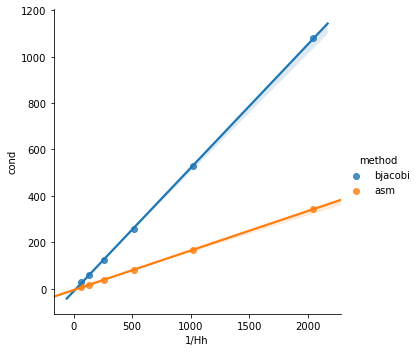

In [114]:
%matplotlib inline
import pandas
import seaborn
df = pandas.read_csv('results.csv')
n1 = 2**(df.refine + 1) # number of points per dimension
df['P'] = 16      # number of processes
df['N'] = n1**2    # number of dofs in global problem
df['h'] = 1/n1
df['H'] = 0.25 # 16 procs = 4x4 process grid
df['1/Hh'] = 1/(df.H * df.h)

seaborn.lmplot(x='1/Hh', y='cond', hue='method', data=df)
df

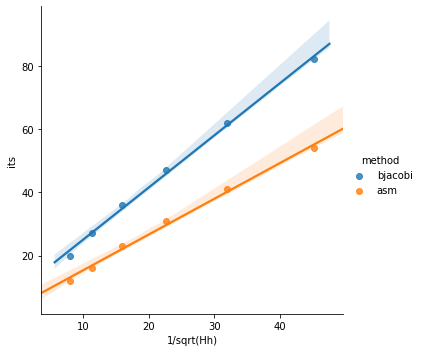

In [122]:
import numpy as np
df['1/sqrt(Hh)'] = np.sqrt(df['1/Hh'])
seaborn.lmplot(x='1/sqrt(Hh)', y='its', hue='method', data=df);

#### Cost
Let $n = N/P$ be the subdomain size and suppose $k$ iterations are needed.

* Matrix assembly scales like $O(n)$ (perfect parallelism)
* 2D factorization in each subdomain scales as $O(n^{3/2})$
* Preconditioner application scales like $O(n \log n)$
* Matrix multiplication scales like $O(n)$
* GMRES scales like $O(k^2 n) + O(k^2 \log P)$
  * With restart length $r \ll k$, GMRES scales with $O(krn) + O(kr\log P)$

In [126]:
! mpiexec -n 2 --oversubscribe ./ex29 -da_refine 8 -pc_type asm -sub_pc_type lu -ksp_converged_reason -log_view

Linear solve converged due to CONVERGED_RTOL iterations 25
************************************************************************************************************************
***             WIDEN YOUR WINDOW TO 120 CHARACTERS.  Use 'enscript -r -fCourier9' to print this document            ***
************************************************************************************************************************

---------------------------------------------- PETSc Performance Summary: ----------------------------------------------

./ex29 on a ompi-optg named joule.int.colorado.edu with 2 processors, by jed Wed Oct 16 10:57:30 2019
Using Petsc Development GIT revision: v3.12-32-g78b8d9f084  GIT Date: 2019-10-03 10:45:44 -0500

                         Max       Max/Min     Avg       Total 
Time (sec):           1.484e+00     1.000   1.484e+00
Objects:              1.040e+02     1.000   1.040e+02
Flop:                 1.432e+09     1.004   1.429e+09  2.857e+09
Flop/sec:          

## Suggested exercises

* There is no substitute for experimentation.  Try some different methods or a different example.  How do the constants and scaling compare?
* Can you estimate parameters to model the leading costs for this solver?
  * In your model, how does degrees of freedom solved per second per process depend on discretization size $h$?
  * What would be optimal?